In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel("ERROR")
tf.__version__

2025-07-16 14:42:01.677264: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 14:42:01.765659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752658921.818875   13731 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752658921.837412   13731 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752658921.928731   13731 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

'2.19.0'

In [2]:
train_dataset = h5py.File('datasets/train_signs.h5')
test_dataset = h5py.File('datasets/test_signs.h5')

In [3]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset["train_set_x"])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset["train_set_y"])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset["test_set_x"])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset["test_set_y"])

I0000 00:00:1752658928.001260   13731 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
type(x_train)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

### Check Shape

In [5]:
# Single Training Example
print(x_train.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [6]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [7]:
unique_labels = set()
for element in y_train:
    unique_labels.add(element.numpy())
print(unique_labels)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}


2025-07-16 14:42:08.468509: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Normalize

In [8]:
def normalize(image):
    image = tf.cast(image, tf.float32) /255.0
    image = tf.reshape(image, [-1,])
    return image

In [9]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [10]:
new_train.element_spec

TensorSpec(shape=(12288,), dtype=tf.float32, name=None)

In [11]:
next(iter(new_train))

<tf.Tensor: shape=(12288,), dtype=float32, numpy=
array([0.8901961 , 0.8627451 , 0.8392157 , ..., 0.8156863 , 0.81960785,
       0.81960785], shape=(12288,), dtype=float32)>

### Linear Function

In [12]:
def linear_function():
    np.random.seed(1)

    X = tf.constant(np.random.randn(3,1), name = "X")
    W = tf.Variable(np.random.randn(4,3), name = "W")
    b = tf.Variable(np.random.randn(4,1), name = "b")
    Y = tf.add(tf.matmul(W, X) , b)

    return Y

In [13]:
result = linear_function()
print(result)

tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)


### Sigmoid

In [14]:
def sigmoid(z):
    z = tf.cast(z, tf.float32)
    a = tf.keras.activations.sigmoid(z)
    return a

In [15]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.9999938, shape=(), dtype=float32)


### One Hot Labels

In [16]:
def one_hot_matrix(label, C=6):
    one_hot = tf.reshape(tf.one_hot(label, C, axis=0), [C,])
    return one_hot

In [17]:
result = one_hot_matrix([2], 5)
print(result)

tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


In [18]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [19]:
next(iter(new_y_test))

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>

### Initialization

In [20]:
def initialize_parameters():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=1)

    parameters = {}

    parameters["W1"] = tf.Variable(initializer(shape=(25,12288)))
    parameters["b1"] = tf.Variable(initializer(shape=(25,1)))
    parameters["W2"] = tf.Variable(initializer(shape=(12,25)))
    parameters["b2"] = tf.Variable(initializer(shape=(12,1)))
    parameters["W3"] = tf.Variable(initializer(shape=(6,12)))
    parameters["b3"] = tf.Variable(initializer(shape=(6,1)))

    return parameters

In [21]:
parameters = initialize_parameters()

for key in parameters:
    print(f"{key} shape: {tuple(parameters[key].shape)}")

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)


### Forward Propagation

In [22]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3, A2), b3)

    return Z3

### Cost Function

In [23]:
def compute_total_loss(logits, labels):
    total_loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(tf.transpose(labels), tf.transpose(logits), from_logits=True))
    return total_loss

### Model Training

In [24]:
def model(xtr, ytr, xtt, ytt, lr=0.0001, num_epochs=1500, minibatch_size=32, print_cost=True):
    cost = []
    train_acc = []
    test_acc = []

    parameters = initialize_parameters()

    W1 = parameters["W1"] 
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    optimizer = tf.keras.optimizers.Adam(lr)

    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()

    dataset = tf.data.Dataset.zip((xtr, ytr))
    test_dataset = tf.data.Dataset.zip((xtt, ytt))

    m = dataset.cardinality().numpy()

    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    
    for epoch in range(num_epochs):
        epoch_cost = 0
        train_accuracy.reset_state()

        for (minibatch_x, minibatch_y) in minibatches:
            with tf.GradientTape() as tape:
                Z3 = forward_propagation(tf.transpose(minibatch_x), parameters)
                mini_batch_cost = compute_total_loss(Z3, tf.transpose(minibatch_y))
                
            train_accuracy.update_state(minibatch_y, tf.transpose(Z3))

            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(mini_batch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += mini_batch_cost

        epoch_cost /= m

        if print_cost and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print("Train accuracy:", train_accuracy.result())

            for (minibatch_x, minibatch_y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_x), parameters)
                test_accuracy.update_state(minibatch_y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())

            cost.append(epoch_cost)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_state()

    
    return parameters, cost, train_acc, test_acc

In [25]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

2025-07-16 14:42:11.605471: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 0: 1.829571
Train accuracy: tf.Tensor(0.175, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.2, shape=(), dtype=float32)


2025-07-16 14:42:12.394961: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-16 14:42:15.676593: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 10: 1.548388
Train accuracy: tf.Tensor(0.37592593, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.30833334, shape=(), dtype=float32)


2025-07-16 14:42:22.164413: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 20: 1.344092
Train accuracy: tf.Tensor(0.50555557, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.45, shape=(), dtype=float32)


2025-07-16 14:42:37.533975: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 30: 1.159936
Train accuracy: tf.Tensor(0.6175926, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.525, shape=(), dtype=float32)
Cost after epoch 40: 1.032866
Train accuracy: tf.Tensor(0.65925926, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.5833333, shape=(), dtype=float32)
Cost after epoch 50: 0.944280
Train accuracy: tf.Tensor(0.6824074, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.6166667, shape=(), dtype=float32)


2025-07-16 14:43:05.220673: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 60: 0.877299
Train accuracy: tf.Tensor(0.7074074, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.6333333, shape=(), dtype=float32)
Cost after epoch 70: 0.824381
Train accuracy: tf.Tensor(0.73055553, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.6666667, shape=(), dtype=float32)
Cost after epoch 80: 0.779951
Train accuracy: tf.Tensor(0.7416667, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.675, shape=(), dtype=float32)
Cost after epoch 90: 0.742958
Train accuracy: tf.Tensor(0.7537037, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.69166666, shape=(), dtype=float32)


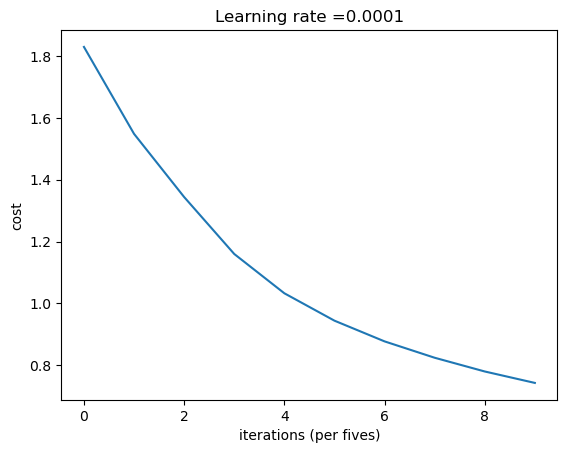

In [26]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


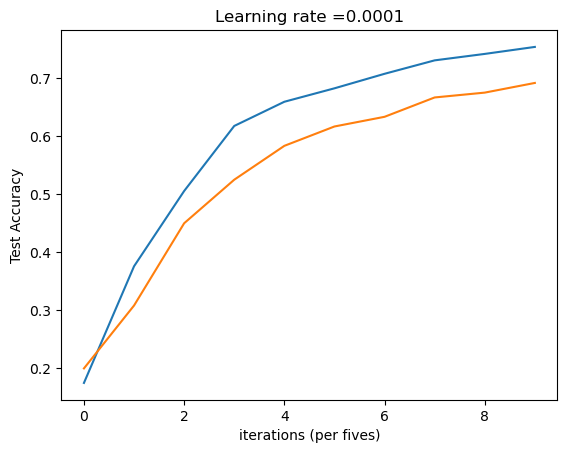

In [27]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()
